<a href="https://colab.research.google.com/github/ptl-harsh/DL_Lab/blob/main/DL_Lab5_04_Sept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Design and implement a CNN model (with 2 layers of convolutions) to classify
multi category image datasets. Record the accuracy corresponding to the number of
epochs. Use the MNIST, CIFAR-10 datasets.

In [2]:


import os, json, csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))
os.makedirs("outputs", exist_ok=True)


TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def load_data(name: str):
    """
    Returns (x_train, y_train, x_test, y_test, input_shape, num_classes).
    """
    name = name.lower()
    if name == "mnist":
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        x_train = x_train[..., np.newaxis]  # (28,28) -> (28,28,1)
        x_test  = x_test[..., np.newaxis]
        input_shape = (28, 28, 1)
        num_classes = 10
    elif name in ("cifar10", "cifar-10"):
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
        input_shape = (32, 32, 3)
        num_classes = 10
    else:
        raise ValueError("name must be 'mnist' or 'cifar10'")

    x_train = x_train.astype("float32") / 255.0
    x_test  = x_test.astype("float32") / 255.0
    y_train = y_train.reshape(-1)
    y_test  = y_test.reshape(-1)
    return x_train, y_train, x_test, y_test, input_shape, num_classes


In [4]:
def build_two_conv_cnn(input_shape, num_classes, dropout=0.25, dense_units=128):
    inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)   # 1st conv
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)     # 2nd conv
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inp, out)


In [5]:
def plot_and_save_acc(hist, title, out_png):
    epochs = range(1, len(hist.history["accuracy"]) + 1)
    plt.figure()
    plt.plot(epochs, hist.history["accuracy"], label="train_acc")
    plt.plot(epochs, hist.history["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.savefig(out_png, bbox_inches="tight")
    plt.show()

def save_history_csv(hist, out_csv):
    keys = ["epoch", "accuracy", "val_accuracy", "loss", "val_loss"]
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(keys)
        n = len(hist.history["accuracy"])
        for i in range(n):
            w.writerow([
                i+1,
                hist.history["accuracy"][i],
                hist.history["val_accuracy"][i],
                hist.history["loss"][i],
                hist.history["val_loss"][i],
            ])

def train_dataset(name, epochs=10, batch_size=128, lr=1e-3, val_split=0.1):
    x_tr, y_tr, x_te, y_te, in_shape, n_cls = load_data(name)
    model = build_two_conv_cnn(in_shape, n_cls)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    print(f"\n=== Training on {name.upper()} ===")
    hist = model.fit(
        x_tr, y_tr,
        validation_split=val_split,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
    )

    test_loss, test_acc = model.evaluate(x_te, y_te, verbose=0)
    print(f"{name.upper()} Test Accuracy: {test_acc:.4f}")

    png_path = f"outputs/{name.lower()}_acc_curve.png"
    csv_path = f"outputs/{name.lower()}_history.csv"
    plot_and_save_acc(hist, f"{name.upper()} Accuracy vs Epochs", png_path)
    save_history_csv(hist, csv_path)

    # Pretty per-epoch table
    print(f"\n{name.upper()} per-epoch:")
    print("Epoch | Train_Acc | Val_Acc | Train_Loss | Val_Loss")
    for i in range(len(hist.history["accuracy"])):
        print(f"{i+1:>5} | {hist.history['accuracy'][i]:>9.4f} | {hist.history['val_accuracy'][i]:>7.4f} | "
              f"{hist.history['loss'][i]:>10.4f} | {hist.history['val_loss'][i]:>8.4f}")

    return model, hist, test_acc


In [6]:
EPOCHS = 10       # increase for better accuracy if desired
BATCH_SIZE = 128
LR = 1e-3
VAL_SPLIT = 0.1


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

=== Training on MNIST ===
Epoch 1/10
422/422 - 10s - 24ms/step - accuracy: 0.9352 - loss: 0.2162 - val_accuracy: 0.9842 - val_loss: 0.0591
Epoch 2/10
422/422 - 3s - 7ms/step - accuracy: 0.9807 - loss: 0.0618 - val_accuracy: 0.9862 - val_loss: 0.0469
Epoch 3/10
422/422 - 2s - 4ms/step - accuracy: 0.9864 - loss: 0.0440 - val_accuracy: 0.9890 - val_loss: 0.0388
Epoch 4/10
422/422 - 2s - 4ms/step - accuracy: 0.9888 - loss: 0.0350 - val_accuracy: 0.9903 - val_loss: 0.0347
Epoch 5/10
422/422 - 3s - 7ms/step - accuracy: 0.9906 - loss: 0.0274 - val_accuracy: 0.9897 - val_loss: 0.0373
Epoch 6/10
422/422 - 2s - 5ms/step - accuracy: 0.9919 - loss: 0.0242 - val_accuracy: 0.9902 - val_loss: 0.0345
Epoch 7/10
422/422 - 2s - 4ms/step - accuracy: 0.9931 - loss: 0.0212 - val_accuracy: 0.9920 - val_loss: 0.0300
Epoch 8/10
422/422 - 3s - 6ms/step - accuracy: 0.9945 - loss: 0.0168 - val_accuracy: 0.9932 - val_loss: 0.0267
Epoch 9/10
422/422 - 2s - 4ms/st

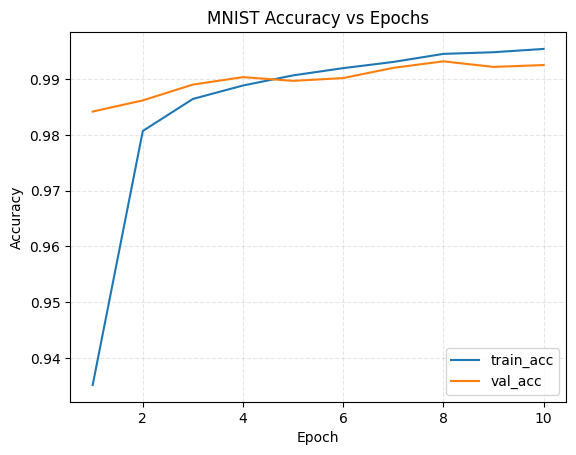


MNIST per-epoch:
Epoch | Train_Acc | Val_Acc | Train_Loss | Val_Loss
    1 |    0.9352 |  0.9842 |     0.2162 |   0.0591
    2 |    0.9807 |  0.9862 |     0.0618 |   0.0469
    3 |    0.9864 |  0.9890 |     0.0440 |   0.0388
    4 |    0.9888 |  0.9903 |     0.0350 |   0.0347
    5 |    0.9906 |  0.9897 |     0.0274 |   0.0373
    6 |    0.9919 |  0.9902 |     0.0242 |   0.0345
    7 |    0.9931 |  0.9920 |     0.0212 |   0.0300
    8 |    0.9945 |  0.9932 |     0.0168 |   0.0267
    9 |    0.9948 |  0.9922 |     0.0147 |   0.0307
   10 |    0.9954 |  0.9925 |     0.0126 |   0.0300


In [7]:
mnist_model, mnist_hist, mnist_test_acc = train_dataset(
    "mnist", epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, val_split=VAL_SPLIT
)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

=== Training on CIFAR10 ===
Epoch 1/10
352/352 - 10s - 29ms/step - accuracy: 0.4498 - loss: 1.5417 - val_accuracy: 0.5632 - val_loss: 1.2630
Epoch 2/10
352/352 - 3s - 9ms/step - accuracy: 0.5836 - loss: 1.1851 - val_accuracy: 0.6216 - val_loss: 1.0984
Epoch 3/10
352/352 - 2s - 7ms/step - accuracy: 0.6310 - loss: 1.0573 - val_accuracy: 0.6508 - val_loss: 1.0084
Epoch 4/10
352/352 - 3s - 7ms/step - accuracy: 0.6675 - loss: 0.9529 - val_accuracy: 0.6940 - val_loss: 0.9057
Epoch 5/10
352/352 - 2s - 6ms/step - accuracy: 0.6877 - loss: 0.8914 - val_accuracy: 0.6970 - val_loss: 0.8986
Epoch 6/10
352/352 - 2s - 7ms/step - accuracy: 0.7091 - loss: 0.8339 - val_accuracy: 0.7034 - val_loss: 0.8848
Epoch 7/10
352/352 - 2s - 6ms/step - accuracy: 0.7255 - loss: 0.7830 - val_accuracy: 0.6936 - val_loss: 0.8910
Epoch 8/10
352/352 - 3s - 7ms/step - accuracy: 0.7401 - loss: 0.7454 - val_accuracy: 0.7200 - val_loss: 0.8428
Epoch 9/10
352/352 - 2s - 6m

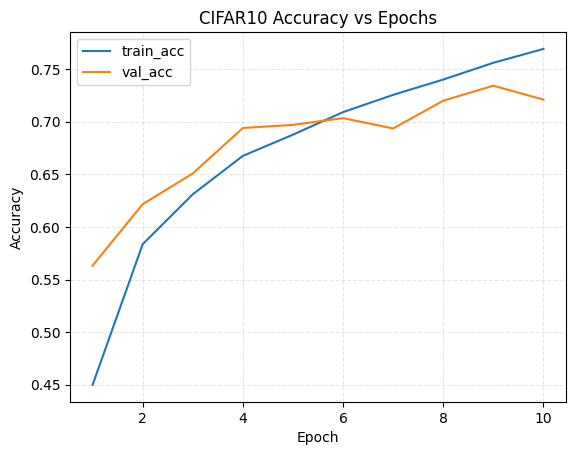


CIFAR10 per-epoch:
Epoch | Train_Acc | Val_Acc | Train_Loss | Val_Loss
    1 |    0.4498 |  0.5632 |     1.5417 |   1.2630
    2 |    0.5836 |  0.6216 |     1.1851 |   1.0984
    3 |    0.6310 |  0.6508 |     1.0573 |   1.0084
    4 |    0.6675 |  0.6940 |     0.9529 |   0.9057
    5 |    0.6877 |  0.6970 |     0.8914 |   0.8986
    6 |    0.7091 |  0.7034 |     0.8339 |   0.8848
    7 |    0.7255 |  0.6936 |     0.7830 |   0.8910
    8 |    0.7401 |  0.7200 |     0.7454 |   0.8428
    9 |    0.7560 |  0.7342 |     0.6955 |   0.7871
   10 |    0.7692 |  0.7210 |     0.6601 |   0.8175


In [8]:
cifar_model, cifar_hist, cifar_test_acc = train_dataset(
    "cifar10", epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, val_split=VAL_SPLIT
)


In [9]:
print("\n=== Summary ===")
print(f"MNIST  Test Accuracy : {mnist_test_acc:.4f}")
print(f"CIFAR10 Test Accuracy : {cifar_test_acc:.4f}")
print("Saved files:")
print("- outputs/mnist_acc_curve.png")
print("- outputs/mnist_history.csv")
print("- outputs/cifar10_acc_curve.png")
print("- outputs/cifar10_history.csv")



=== Summary ===
MNIST  Test Accuracy : 0.9927
CIFAR10 Test Accuracy : 0.7109
Saved files:
- outputs/mnist_acc_curve.png
- outputs/mnist_history.csv
- outputs/cifar10_acc_curve.png
- outputs/cifar10_history.csv
